<a id="top"></a>
# NLP Review Classification
---

**Project Outline**: 


A multi-class classification project utilising natural language processing techniques to classify hotel reviews (ratings 1 - 5) from the popular travel booking site TripAdvisor. After scraping reviews from TripAdvisor and combining them with existing data, I cleaned and preprocessed them before building several different models that attempted to predict the rating of the reviews. The best model turned out to be BERT (Bidirectional Encoder Representations from Transformers), a pretrained model that had an accuracy of 62% on the test set.

## Contents
---

**1.  [Overview](#overview)** <br>
**2.  [Statistical Summary of Models](#statistical_summary)** <br>
**3.  [Data Reading & Checking](#data_checking)** <br>
**4.  [Data Cleaning & EDA](#data_cleaning_eda)** <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.1.  [Tokenization](#tokenization)** <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**4.2.  [Lemmatization](#lemmatization)** <br>

<a id="overview"></a>
## 1. Overview
---

**Problem Statement**

Today, reviews form a big part of society and many people rely heavily on them when making decisions about purchasing goods and services. Reviews not only help to inform people but they can also be extremely useful for identifying where businesses need to improve. Because of this, businesses often encourage people to leave reviews and ratings of their products or services. 

While many people do leave reviews and ratings, many others share their thoughts and feelings about particular goods and services in a variety of different public places, such as forums, blogs or even through social media channels.

Given the usefulness of this feedback, it could be beneficial for a business to develop a methodology to find these reviews and attempt to estimate what rating that person would have given for the good or service that they recieved. 

Processing textual information like this could give businesses a more comprehenisve understanding of how their products and services are perceived by consumers which could help them make business critical decisions.

---

**Obtaining the Reviews**

- While I was able to find some existing review data from TripAdvisor on Kaggle, the data was heavily imbalanced in favour of higher ratings. Because of this, I built a script using BeautifulSoup and Selenium to scrape reviews from the TripAdvisor website. When looking for hotels to scrape, I focussed on big capital cities that usually have a lot of hotel guests throughout the year. I picked London, Paris and Berlin and tried to find hotels that had a good mix of positive and negative reviews. Despite this, the majority of hotels had ratings of either 4 or 5. In total, I scraped reviews from 33 hotels, 11 from each city.


**Splitting the Notebooks**

- Given the computational resources required for training, much of the model building phase of the project was carried out in separate notebooks on Google Colab.


**Deployment**

- After finding a model that performed well, I deployed it as an app to Streamlit, allowing users to enter a review and receive a predicted rating for it. The app can be found at XXXX.

<a id="statistical_summary"></a>
## 2. Statistical Summary of Models
---

Include table with all of the regular algorithms.

Include table with the 3 neural networks and the pretrained model.

<a id="data_checking"></a>
## 3. Data Reading & Checking
---

In [1]:
# Imports
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# Set plot style
sns.set(style='darkgrid', palette='muted')

In [2]:
# View all filepaths in data directory
filepaths = []
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        filepaths.append(os.path.join(dirname, filename))
filepaths

In [4]:
# Extract filepaths that contain hotel reviews
hotel_reviews = [f for f in filepaths if "hotel" in f]

As we have two sources of data containing reviews from TripAdvisor, we will read the data in and then concatentate them.

In [5]:
# Read data
df1 = pd.read_csv(hotel_reviews[0])
df2 = pd.read_csv(hotel_reviews[1])

In [6]:
# Concatenate dataframes
df = pd.concat([df1, df2], axis=0, ignore_index=True)

In [7]:
# Check data
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
48443,Hotel Itself.Three of us stayed in three rooms...,4
48444,We stayed here in late January 2006. We found ...,3
48445,To be honest we booked this hotel because it w...,4
48446,If you are looking for a mid to low range hote...,3


In [8]:
# Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48448 entries, 0 to 48447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  48448 non-null  object
 1   Rating  48448 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 757.1+ KB


In [9]:
# Rating score frequency
df['Rating'].value_counts()

5    18721
4    15025
3     6551
1     4316
2     3835
Name: Rating, dtype: int64

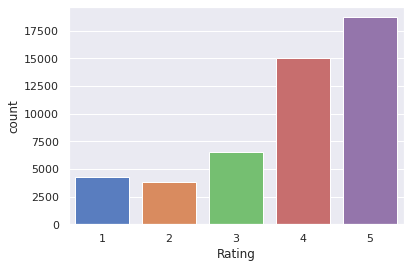

In [10]:
# Plot rating score frequencies
sns.countplot(x=df['Rating']);

Here, we can see that we have a high class imbalance, with the majority of reviews recieving a rating of either 4 or 5.

In [11]:
# Rating score percentages
round(df['Rating'].value_counts()/df.shape[0]*100,2)

5    38.64
4    31.01
3    13.52
1     8.91
2     7.92
Name: Rating, dtype: float64

Combine, ratings of 4 or 5 total just under 70% of the entire data.

In [12]:
# Check for null values
df.isnull().sum()

Review    0
Rating    0
dtype: int64

It looks like we have no missing values.

In [13]:
# Look at an example of a review
df['Review'][2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

Here we can see that the review is quite messy. Amongst other things, it contains numerical data and special characters which usually do not add any additional information. Let's clean the reviews and move onto the EDA phase.

<a id="data_cleaning_eda"></a>
## 4. Data Cleaning & EDA

In [14]:
# Create list of stop words
stop_words = set(stopwords.words('english'))

In [15]:
# Add single characters and numerical suffixes to list of stop words
all_chars = []
all_chars[:] = string.ascii_lowercase # All individual characters
stop_words.update(all_chars) # Update stop_words with all individual characters
stop_words.update(['st', 'nd', 'rd', 'th']) # Update with suffixes after numbers e.g. 1st, 2nd, 3rd, 4th

In our reviews, there are also many words that are very common and do not add much information. To remove these common words, we will use NLTK's predefined list of stop words and add to them some of our own. In particular, we will add all individual characters (lowercase and uppercase) as well as common numerical suffixes such as the 'st' from 1st.

In [16]:
# Remove some words from stop words list that imply sentiment
not_stopwords = {
    "aren", "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "don", "don't", "hadn", 
    "hadn't", "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "mustn", "mustn't", "no", "not", "only",
    "shouldn", "shouldn't", "should've", "wasn", "wasn't", "weren", "weren't", "will", "wouldn", "wouldn't", 
    "won't", "very",  
} 
stop_words = set([word for word in stop_words if word not in not_stopwords])
print(stop_words)

{'he', 'doing', 'our', 'g', "mightn't", 'l', 'p', "you'd", 'from', 'which', 'she', 'yours', 'a', 'in', 'each', 'be', 'while', 't', 'shan', 'is', 'her', 'does', 'was', 'out', 'those', 'but', 'me', 'most', 'such', 'so', 'same', 'by', 'hers', 'st', 'nd', 'do', 'on', 'too', 's', "shan't", 'you', 'did', 'then', 'r', 'were', 'th', 'above', 'herself', 'h', 'the', 'needn', 'if', 'had', 'during', 'n', 'j', 'all', 'why', 'at', 'once', 'they', 'has', 'ma', 'being', 'v', 'and', 'between', 'own', 'my', 'itself', 'further', 'after', 'what', 'theirs', "you're", 'q', 'that', 'k', 'z', 'into', 'll', "that'll", 'them', 'him', 'off', 'than', 'of', 've', 'myself', 'against', 'to', 'both', 'this', 'few', 'himself', "it's", 'e', 'when', 'until', 'm', 'yourselves', 'whom', 'about', 'how', 'who', 'with', 'f', 'some', 'now', 'below', 'w', "you've", 'under', 'any', 'an', 'for', 'am', 'we', 'ourselves', 'rd', 'it', 'your', 'his', 'y', 'yourself', 'i', 'have', 'just', 'these', 'as', 'more', 'won', 'mightn', 'b', 

While the predefined list includes many common words that do not add any additonal information, they also contain common words that might be useful in determining what rating a review is likely to give. Because of this, we will remove some of the words from our list that could help in determining the rating.

In [17]:
# Clean reviews
def clean_reviews(review):
    
    # Make lowercase
    review = review.lower()
    
    # Remove digits and special characters
    review = re.sub('[^a-z]',' ', review)
    
    # Remove stop words
    review = review.split()
    review = " ".join([word for word in review if word not in stop_words])
    
    return review

To make cleaning the reviews easier, we will create a quick function that makes the review lowercase, removes all digits and special characters, and then removes all of the stop words we have defined.

In [18]:
# Before cleaning - example
df['Review'][2]

"nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized, missed 3 separate wakeup calls, concierge busy hard touch, did n't provide guidance special requests.tv hard use ipod sound dock suite non functioning. decided book mediterranean suite 3 night weekend stay 1st choice rest party filled, comparison w spent 45 night larger square footage room great soaking tub whirlpool jets nice shower.before stay hotel arrange car service price 53 tip reasonable driver waiting arrival.checkin easy downside room picked 2 person jacuzi tub no bath accessories salts bubble bath did n't stay, night got 12/1a checked voucher bottle champagne nice gesture fish waiting room, impression room huge open space felt room big, tv far away bed chore change channel, ipod dock broken disappointing.in morning way asked desk check thermostat said 6

This is what a review looks like before cleaning.

In [19]:
# After cleaning - example
clean_reviews(df['Review'][2])

'nice rooms not experience hotel monaco seattle good hotel level positives large bathroom mediterranean suite comfortable bed pillowsattentive housekeeping staffnegatives ac unit malfunctioned stay desk disorganized missed separate wakeup calls concierge busy hard touch provide guidance special requests tv hard use ipod sound dock suite non functioning decided book mediterranean suite night weekend stay choice rest party filled comparison spent night larger square footage room great soaking tub whirlpool jets nice shower stay hotel arrange car service price tip reasonable driver waiting arrival checkin easy downside room picked person jacuzi tub no bath accessories salts bubble bath stay night got checked voucher bottle champagne nice gesture fish waiting room impression room huge open space felt room big tv far away bed chore change channel ipod dock broken disappointing morning way asked desk check thermostat said degrees warm try cover face night bright blue light kept got room nigh

After cleaning, the review looks much better. Let's apply the cleaning to all of our reviews.

In [20]:
# Apply cleaning to all reviews
df['Review'] = df['Review'].map(clean_reviews)

In [21]:
# Check data
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not experience hotel monaco seattle...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5
...,...,...
48443,hotel three us stayed three rooms march got gr...,4
48444,stayed late january found hotel fairly good va...,3
48445,honest booked hotel one cheapest available ver...,4
48446,looking mid low range hotel heart berlin one a...,3


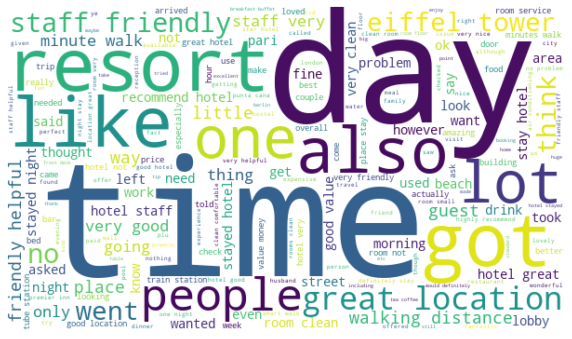

In [22]:
# Wordcloud

# Set up text
text =" ".join(df['Review'].values)
wordcloud = WordCloud(random_state=2, background_color="white", width=600, height=350, stopwords=stop_words)
wordcloud.generate(text)

# Display generated image
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

From the wordcloud, we can see that there may be many common words that do not help in determining the rating related to the review. We will deal with this a little later.

First, let's have a look at the length of all of our reviews by word count.

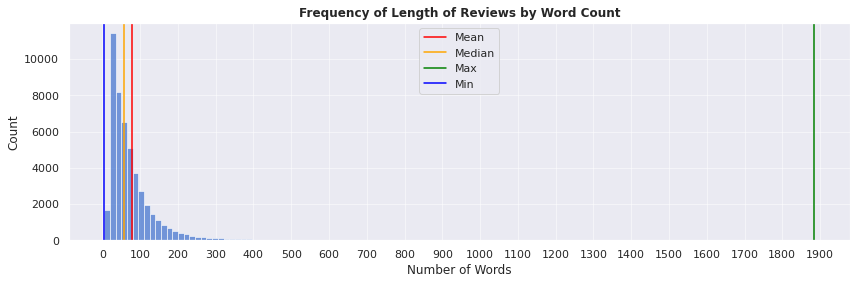

In [23]:
# Plot length of reviews by word count
review_length = [len(x.split()) for x in df['Review']]
plt.figure(figsize=(14, 4))
ax = sns.histplot(review_length, bins=125, zorder=2)
ax.set_xticks(range(0, 2000, 100))
ax.axvline(np.mean(review_length), color='red', label='Mean')
ax.axvline(np.median(review_length), color='orange', label='Median')
ax.axvline(np.max(review_length), color='green', label='Max')
ax.axvline(np.min(review_length), color='blue', label='Min')
plt.grid(alpha=.5)
plt.legend(loc='upper center')
plt.title('Frequency of Length of Reviews by Word Count', fontweight='bold')
plt.xlabel('Number of Words');

In [24]:
# See specific values for min, mean, median and max
print('Reviews')
print('-'*27)
print(f'Min length:\t    {np.min(review_length)} words')
print(f'Mean length:\t   {np.mean(review_length):.0f} words')
print(f'Median length:\t   {np.median(review_length):.0f} words')
print(f'Max length:\t {np.max(review_length)} words')

Reviews
---------------------------
Min length:	    5 words
Mean length:	   78 words
Median length:	   57 words
Max length:	 1885 words


Here, we can see that there is an outlier with a review length that is much longer than the other reviews. It looks like the majority of reviews are 300 words or less so we will remove any reviews which are more than 300 words long.

In [25]:
# Remove reviews which are over 300 words long
df = df[df['Review'].apply(lambda x: len(x.split()) <= 300)]

In [26]:
# Reset index
df = df.reset_index(drop=True)

Let's see what our distribution of review length is now that we have removed all reviews over 300 words long.

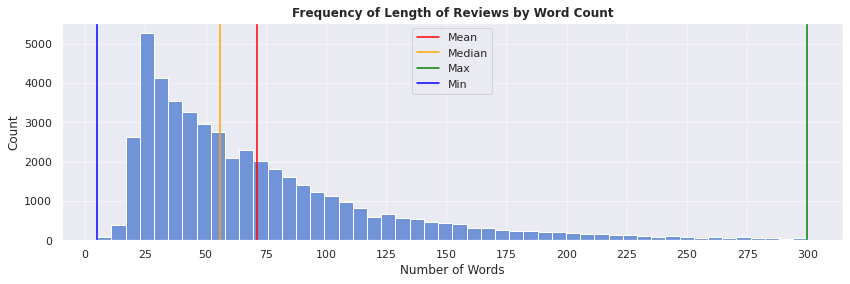

In [27]:
# Plot length of reviews by word count
review_length = [len(x.split()) for x in df['Review']]
plt.figure(figsize=(14, 4))
ax = sns.histplot(review_length, bins=50, zorder=2)
ax.set_xticks(range(0, 301, 25))
ax.axvline(np.mean(review_length), color='red', label='Mean')
ax.axvline(np.median(review_length), color='orange', label='Median')
ax.axvline(np.max(review_length), color='green', label='Max')
ax.axvline(np.min(review_length), color='blue', label='Min')
plt.grid(alpha=.5)
plt.legend(loc='upper center')
plt.title('Frequency of Length of Reviews by Word Count', fontweight='bold')
plt.xlabel('Number of Words');

In [28]:
# See specific values for min, mean, median and max
print('Reviews')
print('-'*27)
print(f'Min length:\t    {np.min(review_length)} words')
print(f'Mean length:\t   {np.mean(review_length):.0f} words')
print(f'Median length:\t   {np.median(review_length):.0f} words')
print(f'Max length:\t  {np.max(review_length)} words')

Reviews
---------------------------
Min length:	    5 words
Mean length:	   71 words
Median length:	   56 words
Max length:	  300 words


This looks much better although it still appears that the majority of reviews are less than 100 words long. Nevertheless, we will continue with what we currently have.

Let's have a look again at our class distribution.

In [29]:
# Rating score frequency
df['Rating'].value_counts()

5    18457
4    14718
3     6431
1     4211
2     3708
Name: Rating, dtype: int64

We still have a large class imbalance, so let's balance them before we move forward. We will take the class which has the lowest count, which in this case is class 2 with 3708 samples, and then randomly drop *n* samples (where *n* is the difference between 3708 and the current samples in the class) from the other classes so that they each only have 3708 samples remaining.

In [30]:
# Randomly drop all reviews above the minimum count (3708) to balance classes

# Create copy of original dataframe
df_bal = df.copy()

# Find the count of the class (rating) with the least instances: in this case there are only 3708 instances 
# for ratings with a score of 2
lowest_count = min(df_bal['Rating'].value_counts())

# Get all classes that have more than the min class
above_min = df_bal['Rating'].value_counts() > lowest_count
ratings_above_min = (above_min)[above_min].index.sort_values().tolist()

# Loop through classes that have more than the min class and randomly drop samples to balance all classes
for i in ratings_above_min:
    total_num = len(df_bal[df_bal['Rating'] == i]) - lowest_count
    df_bal = df_bal.drop(df_bal[df_bal['Rating'] == i].sample(n=total_num, random_state=42).index)
df_bal = df_bal.reset_index(drop=True)

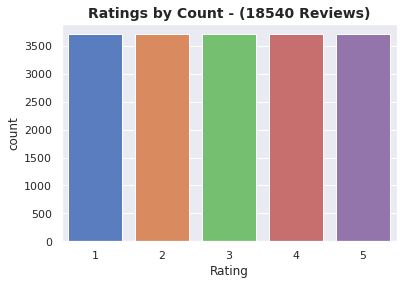

In [31]:
# Plot counts after removal
sns.countplot(x=df_bal['Rating'], zorder=2)
plt.title(f'Ratings by Count - ({df_bal.shape[0]} Reviews)', fontweight='bold', fontsize=14);

In [32]:
# Check value counts
df_bal['Rating'].value_counts()

5    3708
4    3708
3    3708
2    3708
1    3708
Name: Rating, dtype: int64

Now our classes are perfectly balanced.

In [33]:
# Check data
df_bal

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice rooms not experience hotel monaco seattle...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3
...,...,...
18535,dirty halls dirty rooms nothing works tv didn ...,1
18536,confortable rooms staff kind available polite ...,5
18537,stayed attending itb berlin heating system hot...,2
18538,hotel well located adenauerplatz ku damm reaso...,2


<a id="tokenization"></a>
### 4.1. Tokenization
---

Next, we will tokenize our reviews to help us understand more about them. Tokenization, splits the text up into individual items called tokens. In our case, this just splits reviews up into a list of words.

In [35]:
# Before Tokenization - example
df_bal['Review'][2]

'excellent staff housekeeping quality hotel chocked staff make feel home experienced exceptional service desk staff concierge door men maid service needs work maid failed tuck sheets foot bed instance soiled sheets used staff quickley resolved soiled sheets issue guess relates employee not reflection rest staff received excellent advice concierge regarding resturants area happy hour wine tasting nice touch staff went way make feel home great location like close good food shopping took play street theather well pikes market pioneer square access mono rail short walking distance'

In [36]:
# After tokenization - example
tokens = nltk.word_tokenize(df_bal['Review'][2])
print(tokens)

['excellent', 'staff', 'housekeeping', 'quality', 'hotel', 'chocked', 'staff', 'make', 'feel', 'home', 'experienced', 'exceptional', 'service', 'desk', 'staff', 'concierge', 'door', 'men', 'maid', 'service', 'needs', 'work', 'maid', 'failed', 'tuck', 'sheets', 'foot', 'bed', 'instance', 'soiled', 'sheets', 'used', 'staff', 'quickley', 'resolved', 'soiled', 'sheets', 'issue', 'guess', 'relates', 'employee', 'not', 'reflection', 'rest', 'staff', 'received', 'excellent', 'advice', 'concierge', 'regarding', 'resturants', 'area', 'happy', 'hour', 'wine', 'tasting', 'nice', 'touch', 'staff', 'went', 'way', 'make', 'feel', 'home', 'great', 'location', 'like', 'close', 'good', 'food', 'shopping', 'took', 'play', 'street', 'theather', 'well', 'pikes', 'market', 'pioneer', 'square', 'access', 'mono', 'rail', 'short', 'walking', 'distance']


Let's tokenize all of our reviews and add them into a separate column in our dataframe.

In [37]:
# Apply tokenization to all reviews
df_bal['tokenized'] = df_bal['Review'].apply(word_tokenize)

From here, we can also calculate word count for each review as well as the average word length.

In [38]:
# Calculate char_count, word_count, and avg_word_length
df_bal['word_count'] = df_bal['tokenized'].apply(lambda x: len(x))
df_bal['avg_word_length'] = df_bal['tokenized'].apply(lambda x: np.mean([len(word) for word in x]))

In [39]:
# Check data
df_bal.head()

,Review,Rating,tokenized,word_count,avg_word_length
0,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member...",240,5.737500
1,nice rooms not experience hotel monaco seattle...,3,"[nice, rooms, not, experience, hotel, monaco, ...",195,5.692308
2,excellent staff housekeeping quality hotel cho...,4,"[excellent, staff, housekeeping, quality, hote...",86,5.779070
3,poor value stayed monaco seattle july nice hot...,2,"[poor, value, stayed, monaco, seattle, july, n...",43,5.930233
4,nice hotel not nice staff hotel lovely staff q...,3,"[nice, hotel, not, nice, staff, hotel, lovely,...",64,5.031250


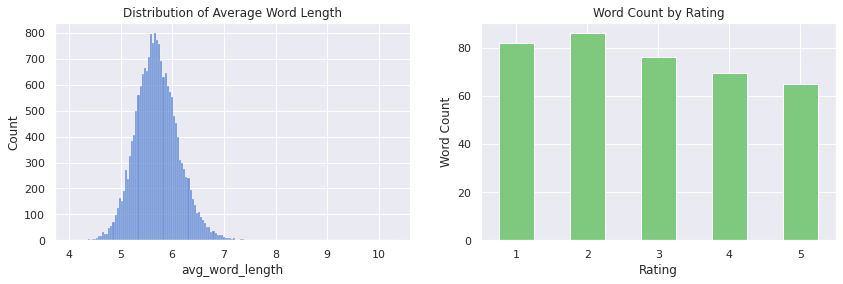

In [40]:
# Plot average word length
fig, axs = plt.subplots(1, 2, figsize=(14,4))

sns.histplot(df_bal['avg_word_length'], ax=axs[0])
axs[0].set_title('Distribution of Average Word Length')

df_bal.groupby('Rating')['word_count'].mean().plot(
    kind='bar', ylabel='Word Count', rot=0, cmap='Accent', ax=axs[1])
axs[1].set_title('Word Count by Rating');

From the distribution above, we can see that average word length is between 5 and 7 and is normally distributed as we would expect. We can also see that the average word count by rating is usually between 60 and 80. What is interesting is that lower ratings tend to have more words per review. This could indicate that people who leave more negative reviews have more to say about their experiences than those who leave more positive reviews.

Now, let's plot the frequency of some of the most common words in our reviews and eliminate those which do not help in determining the rating.

In [41]:
# Function for plotting most common words
def top_words(reviews, n=25):
    """    
    Takes a Series as input and plots the top n most common words.
    """
    all_reviews_joined = " ".join(reviews.values)
    all_tokens = nltk.word_tokenize(all_reviews_joined)
    top = Counter(all_tokens).most_common(n)
    pd.DataFrame(top).set_index([0]).plot(kind='bar', rot=45, figsize=(14,4), zorder=2, legend=False)
    plt.title(f'Top {n} Words by Frequency', fontweight='bold')
    plt.ylabel('frequency')
    plt.xlabel('word')
    plt.grid(alpha=.25);

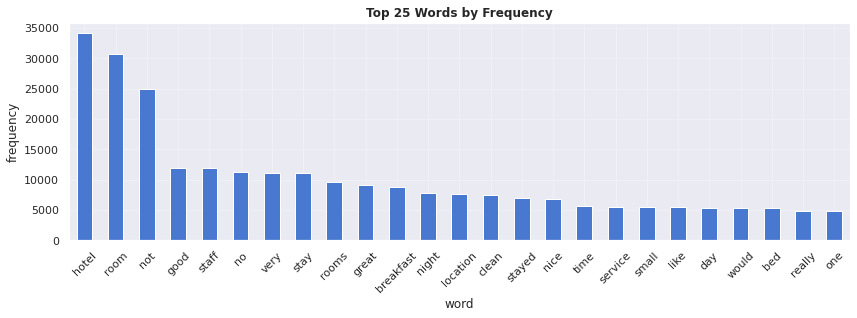

In [42]:
# Top 25 most common words
top_words(df_bal['Review'])

We can see that some of the most common words do not help in determining the rating for a review. For example, words such as 'hotel' and 'room' are likely to be used in reviews of all ratings. Conversely, words such as great and clean could imply a certain sentiment that will help us to determine the rating of a review. We will cycle through the top most common words a few times, removing unecessary words as we go along.

In [43]:
# Remove unnecessary common words
new_stopwords = [
    'hotel', 'room', 'staff', 'stay', 'rooms', 'breakfast', 
    'night', 'location', 'stayed', 'time', 'day', 'bed', 'one'
]
stop_words.update(new_stopwords)
df_bal['Review'] = df_bal['Review'].map(clean_reviews)

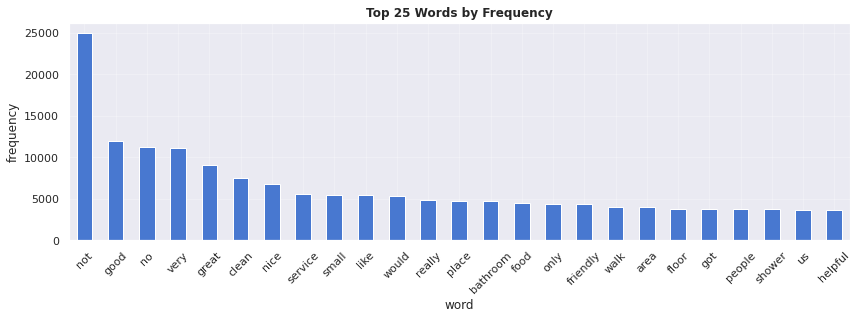

In [44]:
# Top 25 most common words
top_words(df_bal['Review'])

In [45]:
# Remove unnecessary common words
new_stopwords = ['place', 'bathroom', 'food', 'walk', 'area', 'floor', 'got', 'people', 'shower', 'us']
stop_words.update(new_stopwords)
df_bal['Review'] = df_bal['Review'].map(clean_reviews)

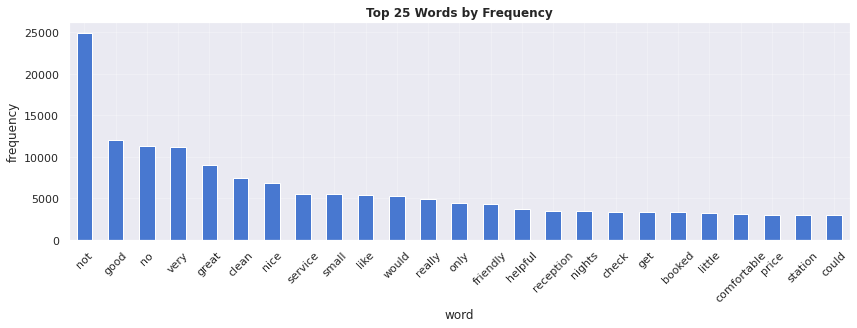

In [46]:
# Top 25 most common words
top_words(df_bal['Review'])

In [47]:
# Remove unnecessary common words
new_stopwords = ['reception', 'nights', 'check', 'get', 'booked', 'station']
stop_words.update(new_stopwords)
df_bal['Review'] = df_bal['Review'].map(clean_reviews)

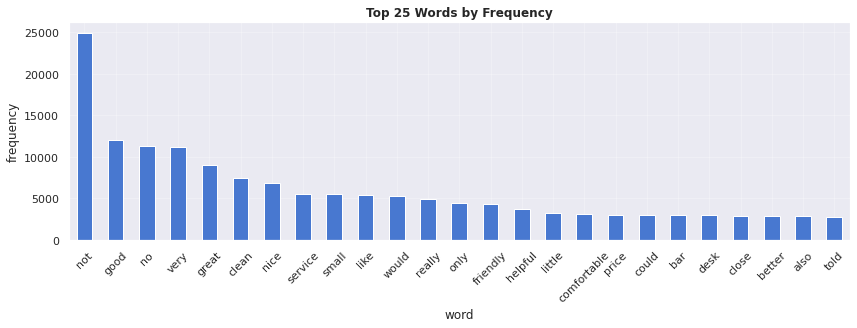

In [48]:
# Top 25 most common words
top_words(df_bal['Review'])

In [49]:
# Remove unnecessary common words
new_stopwords = ['bar', 'desk', 'also', 'told']
stop_words.update(new_stopwords)
df_bal['Review'] = df_bal['Review'].map(clean_reviews)

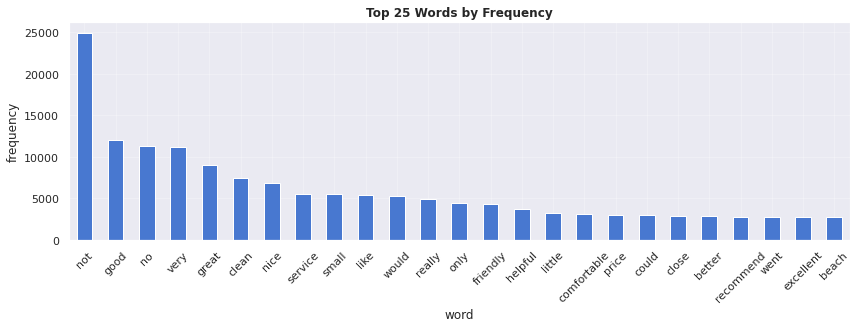

In [50]:
# Top 25 most common words
top_words(df_bal['Review'])

Now we have eliminated some of the most common and unnecessary words, let's plot another wordcloud.

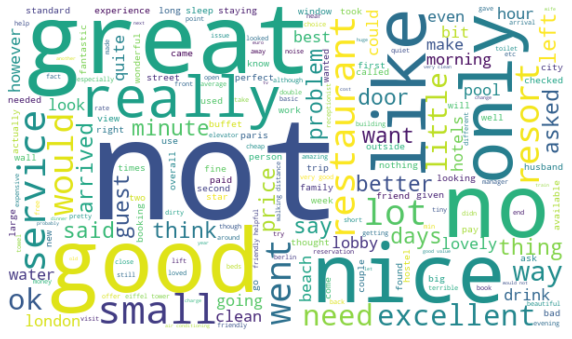

In [51]:
# Wordcloud

# Set up text
text =" ".join(df_bal['Review'].values)
wordcloud = WordCloud(random_state=2, background_color="white", width=600, height=350, stopwords=stop_words)
wordcloud.generate(text)

# Display generated image
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

This looks much better than what we had before.

<a id="lemmatization"></a>
### 4.1. Lemmatization
---

Now, let's go one step further and lemmatize our reviews. The process of lemmatization is when we take a word and covert it into its meaningful base form. For example, the words *runs*, *running* and *ran* are all forms of the base word *run* and thus are converted to this base form. Another similar method which is usually used is called stemming, which reduces words down to their stem, however, this stem may not always be a valid word in the language. An example of this is when the words *argue*, *argues* and *argued* are converted to their stem form *argu*. While stemming can be helpful, in this project, we will just stick to using lemmatization.

In [52]:
# Create lemmatizer object
lemma = WordNetLemmatizer()

In [53]:
# Lemmatize reviews
df_bal['Review'] = df_bal['tokenized'].apply(lambda x: ' '.join([lemma.lemmatize(word) for word in x]))

In [54]:
# Extract just feature and target
df_final = df_bal[['Review', 'Rating']]

In [55]:
# Check data after lemmatization is complete
df_final

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice room not experience hotel monaco seattle ...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3
...,...,...
18535,dirty hall dirty room nothing work tv didn wor...,1
18536,confortable room staff kind available polite g...,5
18537,stayed attending itb berlin heating system hot...,2
18538,hotel well located adenauerplatz ku damm reaso...,2


We now have reviews which are clean, free from some of the most common words, and lemmatized. Let's save our data before we move onto the model building phase.

In [56]:
# Save DataFrame
df_final.to_csv('data/df_final.csv', index=False)

**[Back to Top](#top)**

## Model Building

#### Preparing Data

In [57]:
# Imports
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from model_trainer import TrainModel
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

In [58]:
# Isolate independent and dependent variables
X = df_final['Review']
y = df_final['Rating']

In [59]:
# Split data into training, validation and testing - 80/10/10

# Train 80%, Test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                        stratify=y, random_state=42)

# Valid 10%, Test 10%
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                        stratify=y_test, random_state=42)

In [60]:
# Shapes of data
print('Training Data:')
print('-'*30)
print(f'X = {X_train.shape}')
print(f'y = {y_train.shape}')
print('\nValidation Data:')
print('-'*30)
print(f'X = {X_valid.shape}')
print(f'y = {y_valid.shape}')
print('\nTesting Data:')
print('-'*30)
print(f'X = {X_test.shape}')
print(f'y = {y_test.shape}')

Training Data:
------------------------------
X = (14832,)
y = (14832,)

Validation Data:
------------------------------
X = (1854,)
y = (1854,)

Testing Data:
------------------------------
X = (1854,)
y = (1854,)


In [61]:
# # Apply TF-IDF to data
# tfidf = TfidfVectorizer()
# X_train = tfidf.fit_transform(X_train)
# X_valid = tfidf.transform(X_valid)
# X_test = tfidf.transform(X_test)

In [105]:
# Export training and validation data for model building
train_val = (X_train, X_valid, y_train, y_valid)
pickle.dump(train_val, open('data/train_val_data.pkl', 'wb'))

## Model Evaluation

In [61]:
# Get filenames
saved_models = []
for dirname, _, filenames in os.walk('models'):
    for filename in filenames:
        saved_models.append(os.path.join(dirname, filename))
saved_models

['models/LinearSVC.pkl',
 'models/AdaBoostClassifier.pkl',
 'models/KNeighborsClassifier.pkl',
 'models/StackingClassifier.pkl',
 'models/LGBMClassifier.pkl',
 'models/DecisionTreeClassifier.pkl',
 'models/LogisticRegression.pkl',
 'models/RidgeClassifier.pkl',
 'models/VotingClassifier.pkl',
 'models/SGDClassifier.pkl',
 'models/RandomForestClassifier.pkl',
 'models/MultinomialNB.pkl']

In [62]:
# Unpack all models
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

# Load all models
all_models = []
for m in saved_models:
    with open(f'{m}', 'rb') as f:
        all_models.append(pickle.load(f))

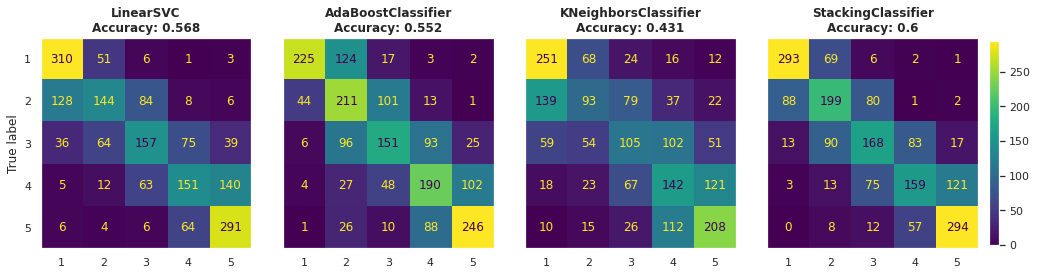

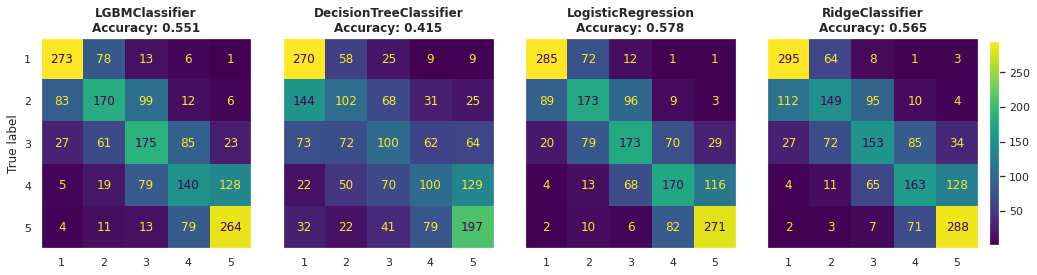

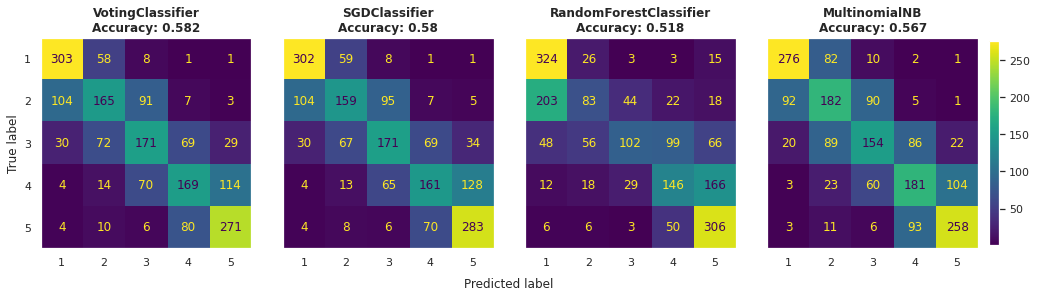

In [63]:
# Confusion matrices for each model - with pipeline
for i in range(3):
    f, axs = plt.subplots(1, 4, figsize=(20, 5), sharey='row')
    for j, m in enumerate(all_models[i*4:(i+1)*4]):
        disp = ConfusionMatrixDisplay(m.confusion_matrix, display_labels=[1,2,3,4,5])
        disp.plot(ax=axs[j])
        disp.ax_.set_title(f'{m.model_name}\nAccuracy: {m.accuracy}', fontweight='bold')
        disp.im_.colorbar.remove()
        disp.ax_.grid(False)
        disp.ax_.set_xlabel('')
        if j != 0:
            disp.ax_.set_ylabel('')
    if i == 2:
        f.text(0.45, 0.1, 'Predicted label', ha='center')
    plt.subplots_adjust(wspace=0.15, hspace=0.1)
    f.colorbar(disp.im_, ax=axs, shrink=0.75, pad=0.01)
    plt.show()

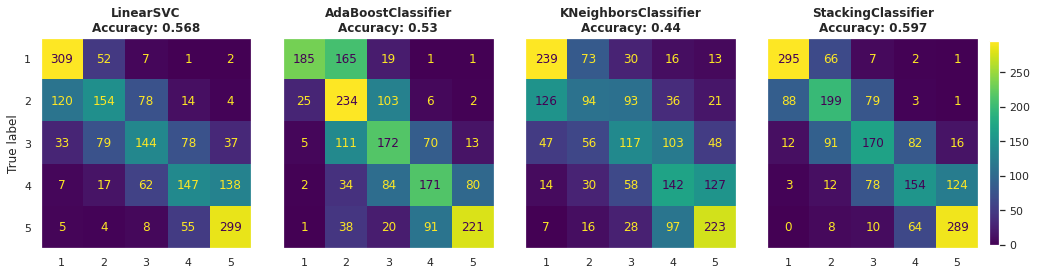

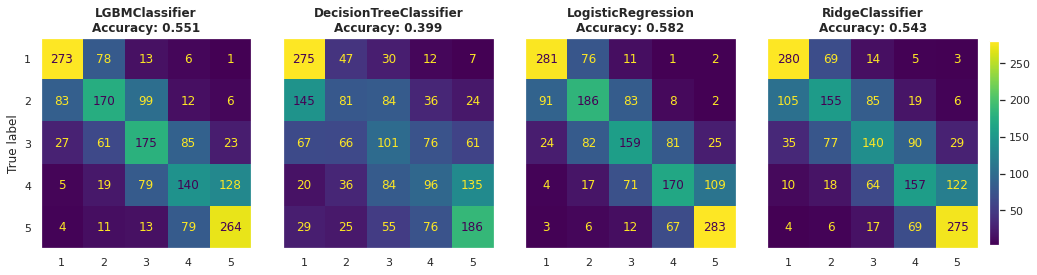

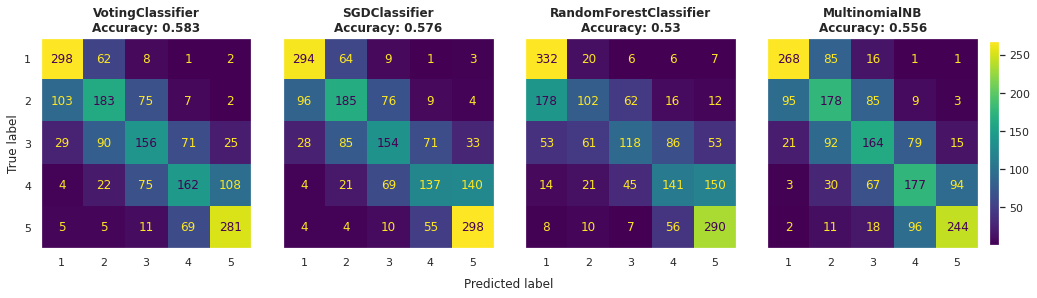

In [78]:
# Confusion matrices for each model - without pipeline
for i in range(3):
    f, axs = plt.subplots(1, 4, figsize=(20, 5), sharey='row')
    for j, m in enumerate(all_models[i*4:(i+1)*4]):
        disp = ConfusionMatrixDisplay(m.confusion_matrix, display_labels=[1,2,3,4,5])
        disp.plot(ax=axs[j])
        disp.ax_.set_title(f'{m.model_name}\nAccuracy: {m.accuracy}', fontweight='bold')
        disp.im_.colorbar.remove()
        disp.ax_.grid(False)
        disp.ax_.set_xlabel('')
        if j != 0:
            disp.ax_.set_ylabel('')
    if i == 2:
        f.text(0.45, 0.1, 'Predicted label', ha='center')
    plt.subplots_adjust(wspace=0.15, hspace=0.1)
    f.colorbar(disp.im_, ax=axs, shrink=0.75, pad=0.01)
    plt.show()

In [64]:
# Model stats - with pipeline
def model_stats(models):
    stats = [(m.model_name, m.accuracy, m.precision, m.f1) for m in models]
    df = pd.DataFrame(stats, columns=['model', 'accuracy', 'precision', 'f1-score']).set_index('model')
    return df

df_models = model_stats(all_models)
df_models.style.highlight_max(axis=0, color='#b3ff66').format("{:.3}")

,accuracy,precision,f1-score
model,,,
LinearSVC,0.568,0.554,0.553
AdaBoostClassifier,0.552,0.569,0.556
KNeighborsClassifier,0.431,0.418,0.419
StackingClassifier,0.6,0.592,0.594
LGBMClassifier,0.551,0.544,0.546
DecisionTreeClassifier,0.415,0.397,0.399
LogisticRegression,0.578,0.571,0.573
RidgeClassifier,0.565,0.552,0.554
VotingClassifier,0.582,0.572,0.574


In [79]:
# Model stats - without pipeline
def model_stats(models):
    stats = [(m.model_name, m.accuracy, m.precision, m.f1) for m in models]
    df = pd.DataFrame(stats, columns=['model', 'accuracy', 'precision', 'f1-score']).set_index('model')
    return df

df_models = model_stats(all_models)
df_models.style.highlight_max(axis=0, color='#b3ff66').format("{:.3}")

,accuracy,precision,f1-score
model,,,
LinearSVC,0.568,0.552,0.552
AdaBoostClassifier,0.53,0.577,0.538
KNeighborsClassifier,0.44,0.427,0.43
StackingClassifier,0.597,0.588,0.591
LGBMClassifier,0.551,0.544,0.546
DecisionTreeClassifier,0.399,0.378,0.381
LogisticRegression,0.582,0.574,0.576
RidgeClassifier,0.543,0.531,0.534
VotingClassifier,0.583,0.572,0.574


In [65]:
# Select StackingClassifier as best model
sc_model = all_models[3]

In [66]:
# A look at the best model
best_model = sc_model.best_estimator
best_model

Pipeline(steps=[('tfidf', TfidfVectorizer(max_df=0.75)),
                ('clf',
                 StackingClassifier(estimators=[('sc1',
                                                 LogisticRegression(max_iter=1000,
                                                                    random_state=42,
                                                                    solver='newton-cg')),
                                                ('sc2',
                                                 RandomForestClassifier(max_depth=30,
                                                                        min_samples_leaf=15,
                                                                        n_estimators=500,
                                                                        random_state=42)),
                                                ('sc3',
                                                 SGDClassifier(loss='log',
                                                          

In [67]:
# Predict test set
preds = best_model.predict(X_test)
accuracy_score(y_test, preds)

0.6051779935275081

In [68]:
# Free up memory
%xdel all_models

In [69]:
# Train model on entire training set 

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# # Apply TF-IDF to data
# tfidf = TfidfVectorizer()
# X_train = tfidf.fit_transform(X_train)
# X_test = tfidf.transform(X_test)

# Fit data
best_model_final = best_model.fit(X_train, y_train)
preds_all = best_model_final.predict(X_test)
accuracy_score(y_test, preds_all)

0.5992448759439051

### Neural Network Model

In [185]:
# from keras.preprocessing import sequence
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout, GlobalAveragePooling1D, Embedding, BatchNormalization
# from keras.layers import Flatten, GlobalMaxPool1D
# from keras.utils import np_utils
# from keras.callbacks import EarlyStopping

In [84]:
# # Plot training and validation accuracy and loss
# def acc_loss_plot(history, epochs):
#     fig, axs = plt.subplots(1, 2, figsize=(15,5))
#     axs[0].plot(history.history['accuracy'], label='Training Accuracy')
#     axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
#     axs[0].legend(loc='lower right')
#     axs[0].set_title('Training and Validation Accuracy')
#     axs[0].set_xticks(range(0, epochs, 2))
#     axs[0].set_xlabel('Epochs')
#     axs[0].set_ylabel('Accuracy')

#     axs[1].plot(history.history['loss'], label='Training Loss')
#     axs[1].plot(history.history['val_loss'], label='Validation Loss')
#     axs[1].legend(loc='upper right')
#     axs[1].set_title('Training and Validation Loss')
#     axs[1].set_xticks(range(0, epochs, 2))
#     axs[1].set_xlabel('Epochs')
#     axs[1].set_ylabel('Loss');

#### Attempt 1

In [85]:
# # Check data
# df_final.head()

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice room not experience hotel monaco seattle ...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3


In [86]:
# # Split data
# X_ann = df_final['Review']
# y_ann = df_final['Rating']
# X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X_ann, y_ann, test_size=.2, 
#                                                                     stratify=y_ann, random_state=42)

In [87]:
# # Vectorize data
# tfidf_ann = TfidfVectorizer()
# X_train_ann = tfidf_ann.fit_transform(X_train_ann)
# X_test_ann = tfidf_ann.transform(X_test_ann)

In [88]:
# # Encode labels
# from sklearn.preprocessing import LabelEncoder
# lb = LabelEncoder()
# y = lb.fit_transform(y_train_ann)
# yt = lb.transform(y_test_ann)

In [89]:
# # Encode
# from keras.utils import np_utils
# y_train_ann  = np_utils.to_categorical(y)
# y_test_ann = np_utils.to_categorical(yt)

In [90]:
# # Create validation set
# X_train_ann, X_val_ann, y_train_ann, y_val_ann = train_test_split(
#     X_train_ann, y_train_ann , test_size=.2, random_state=42
# )

In [92]:
# # Build model
# ann_model = Sequential()
# ann_model.add(Dense(32, input_dim=X_train_ann.shape[1], activation='relu'))
# ann_model.add(Dropout(0.5))
# ann_model.add(Dense(16, activation='relu'))
# ann_model.add(Dropout(0.5))
# ann_model.add(BatchNormalization())
# ann_model.add(Dense(16, activation='relu'))
# ann_model.add(Dense(5, activation='softmax'))

# # Compile
# ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
# # Sort indices
# X_train_ann.sort_indices()
# X_val_ann.sort_indices()
# X_test_ann.sort_indices()

In [94]:
# # Fit data
# epochs = 10
# history = ann_model.fit(X_train_ann, y=y_train_ann, batch_size=128, epochs=epochs, 
#               verbose=0, validation_data=(X_val_ann, y_val_ann))

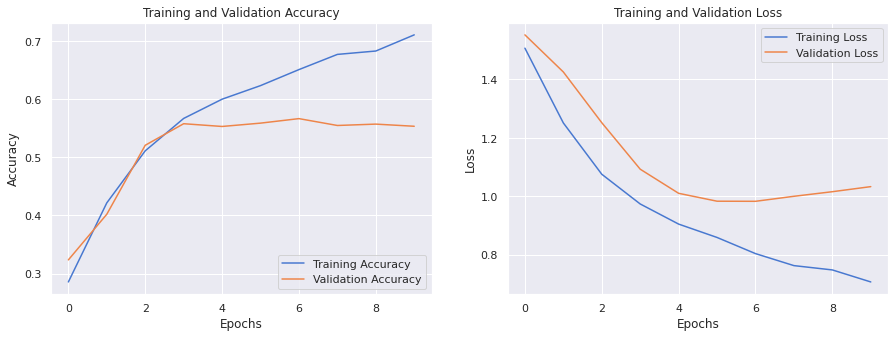

In [95]:
# # Plot accuracy and loss
# acc_loss_plot(history, epochs)

In [96]:
# # Evalate model on validation set
# ann_model.evaluate(X_val_ann, y_val_ann)[1]

93/93 [==============================] - 0s 2ms/step - loss: 1.0328 - accuracy: 0.5534


0.5534209609031677

In [101]:
# # Evalate model on test set
# ann_model.evaluate(X_test_ann, y_test_ann)[1]

116/116 [==============================] - 0s 1ms/step - loss: 1.0206 - accuracy: 0.5653


0.5652642846107483

#### Attempt 2

In [102]:
# # Check data
# df_final.head()

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice room not experience hotel monaco seattle ...,3
2,excellent staff housekeeping quality hotel cho...,4
3,poor value stayed monaco seattle july nice hot...,2
4,nice hotel not nice staff hotel lovely staff q...,3


In [103]:
# # One hot encode target variables
# df_ohe = pd.get_dummies(df_final, columns=['Rating'])
# df_ohe

,Review,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5
0,ok nothing special charge diamond member hilto...,0,1,0,0,0
1,nice room not experience hotel monaco seattle ...,0,0,1,0,0
2,excellent staff housekeeping quality hotel cho...,0,0,0,1,0
3,poor value stayed monaco seattle july nice hot...,0,1,0,0,0
4,nice hotel not nice staff hotel lovely staff q...,0,0,1,0,0
...,...,...,...,...,...,...
18535,dirty hall dirty room nothing work tv didn wor...,1,0,0,0,0
18536,confortable room staff kind available polite g...,0,0,0,0,1
18537,stayed attending itb berlin heating system hot...,0,1,0,0,0
18538,hotel well located adenauerplatz ku damm reaso...,0,1,0,0,0


In [104]:
# # Split data into training and test
# X_ohe = df_ohe.loc[:,['Review']]
# y_ohe = df_ohe.drop('Review', axis=1)
# X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=.2, random_state=42)

In [105]:
# # Join all reviews in training set and split
# all_words_train = " ".join(X_train_ohe['Review'].values).split()

In [106]:
# # All words
# len(all_words_train)

1125523

In [107]:
# # Get all unique words only
# unique_words_train = set(all_words_train)

In [108]:
# # Number of unique words
# len(unique_words_train)

30105

In [109]:
# # Factorize all unique words (assign each word a unique number)
# unique_numbers = pd.factorize(list(unique_words_train))[0]

In [111]:
# list(zip(unique_words_train, unique_numbers))[:10]

[('diharea', 0),
 ('reponse', 1),
 ('overstated', 2),
 ('lava', 3),
 ('nettie', 4),
 ('makeover', 5),
 ('enthused', 6),
 ('staycation', 7),
 ('eye', 8),
 ('gerbil', 9)]

In [112]:
# # Create dictionary for word and unique number
# word_number_zip = zip(unique_words_train, unique_numbers)
# word_number_dict = dict((x, y) for x, y in list(word_number_zip))

In [113]:
# # Adding padding and other representations
# word_number_dict = {k:(v+2) for k,v in word_number_dict.items()}
# word_number_dict['<PAD>'] = 0
# word_number_dict['<UNK>'] = 1

In [114]:
# # Size of dict
# len(word_number_dict)

30107

In [115]:
# # Prevent SettingWithCopyWarning
# pd.options.mode.chained_assignment = None

In [116]:
# # Function for transforming reviews into numbers - can we use mapping here?
# X_train_ohe['encoded_review'] = X_train_ohe['Review'].str.split().map(
#     lambda x: [word_number_dict.get(word, word_number_dict['<UNK>']) for word in x]
# )

In [117]:
# # Check data
# X_train_ohe

,Review,encoded_review
1127,worst vacation start planned trip trip lifetim...,"[12892, 2243, 1701, 14677, 4726, 4726, 8237, 1..."
6725,nice hotel let attention communication staff p...,"[2434, 16533, 12485, 12225, 23466, 24750, 1945..."
4966,amazing staff stayed hotel night honeymoon flo...,"[5242, 24750, 24070, 16533, 24367, 10004, 1114..."
1799,booked arrived no room available received pre ...,"[7736, 22051, 25112, 23768, 26437, 17020, 1104..."
4484,stay wish read tripadvisor san francisco ca re...,"[19239, 15897, 6785, 17764, 1147, 11418, 19736..."
...,...,...
11284,usually check trip advisor booking hotel seein...,"[28838, 20543, 4726, 20284, 26409, 16533, 3056..."
11964,bathroom stunk damp floor looked pretty water ...,"[25589, 581, 2737, 859, 24935, 1239, 15164, 17..."
5390,not great colleague recommended stay intercont...,"[16395, 3340, 11452, 6595, 19239, 28428, 29432..."
860,yuck stayed recommendation tripadvisor member ...,"[27599, 24070, 4205, 17764, 13402, 6241, 17734..."


In [118]:
# # Transform test set
# X_test_ohe['encoded_review'] = X_test_ohe['Review'].str.split().map(
#     lambda x: [word_number_dict.get(word, word_number_dict['<UNK>']) for word in x]
# )

In [119]:
# # Check data
# X_test_ohe

,Review,encoded_review
10158,bad point overpriced minimalist standard room ...,"[4462, 8168, 5367, 18946, 23754, 23768, 23111,..."
3617,quiet comfortable chose stay bassano review tr...,"[15258, 25961, 23390, 19239, 1, 24764, 17764, ..."
4894,return trip city inn excellent stayed city inn...,"[17874, 4726, 15247, 10365, 17578, 24070, 1524..."
2315,great unless looking super critical hotel diff...,"[3340, 23286, 7271, 19015, 11670, 16533, 18619..."
2177,need improvement got trip punta cana july july...,"[18355, 29482, 9632, 4726, 21905, 17989, 13218..."
...,...,...
9049,very pleasant stay idea location u visiting ar...,"[13757, 13691, 19239, 13111, 27265, 21027, 244..."
14758,great view eiffel tower concierge front desk v...,"[3340, 9455, 11012, 7005, 27402, 8600, 4061, 1..."
6779,ok hotel significant lapse ok hotel let not cr...,"[24199, 16533, 27259, 28449, 24199, 16533, 124..."
3269,great stay tulipn inn amsterdam west great sta...,"[3340, 19239, 1, 10365, 19818, 1337, 3340, 192..."


In [120]:
# # Add padding to reviews and cap (train & test)
# X_train_ohe = sequence.pad_sequences(
#     X_train_ohe['encoded_review'], value=word_number_dict['<PAD>'], padding='post', maxlen=200
# )

# X_test_ohe = sequence.pad_sequences(
#     X_test_ohe['encoded_review'], value=word_number_dict['<PAD>'], padding='post', maxlen=200
# )

In [121]:
# # Create validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train_ohe, y_train_ohe , test_size=.2, random_state=42)

In [122]:
# # Build model architecture
# model = Sequential()
# model.add(Embedding(len(word_number_dict), 32))
# model.add(GlobalAveragePooling1D())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(5, activation='sigmoid'))

In [123]:
# # View model summary
# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          963424    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 964,645
Trainable params: 964,645
Non-trainable params: 0
_________________________________________________________________


In [124]:
# # Compile model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [125]:
# # Fit model

# # Callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# epochs = 60
# history = model.fit(
#     X_train, y_train, batch_size=250, epochs=epochs, validation_data=(X_val, y_val), 
#     callbacks=[early_stopping], verbose=0
# )

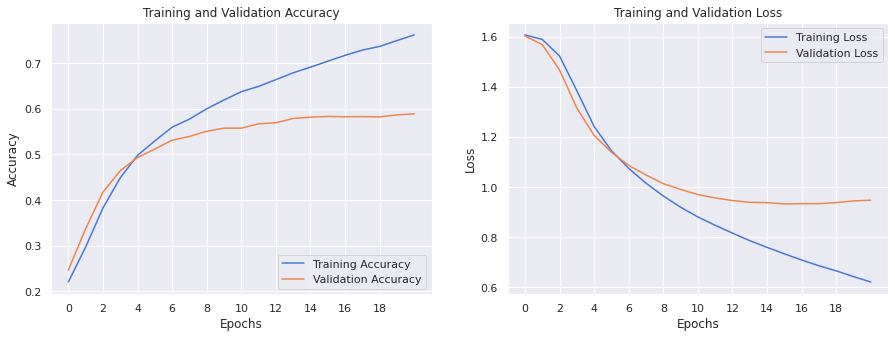

In [126]:
# # Plot accuracy and loss
# last_epoch = early_stopping.stopped_epoch
# acc_loss_plot(history, last_epoch)

In [127]:
# # Evalate model on validation set
# model.evaluate(X_val, y_val)[1]

93/93 [==============================] - 0s 1ms/step - loss: 0.9467 - accuracy: 0.5888


0.5888102650642395

In [128]:
# # Evaluate model on test set
# model.evaluate(X_test_ohe, y_test_ohe)[1]

116/116 [==============================] - 0s 1ms/step - loss: 0.9535 - accuracy: 0.5898


0.5898058414459229

### Pretrained Models

In [152]:
# import ktrain
# from ktrain import text

In [153]:
# df_5_bert = df_5_final.copy()
# df_3_bert = df_3_final.copy()

In [154]:
# df_5_bert

In [155]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df_5_bert['Rating'] = le.fit_transform(df_5_bert['Rating'])

In [156]:
# (x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(df_5_bert, 
#                                                                     'Review',
#                                                                     label_columns=['Rating'],
#                                                                     preprocess_mode='bert')

In [157]:
# model = text.text_classifier(name='bert',
#                              train_data=(x_train, y_train),
#                              preproc=preproc)

In [158]:
# learner = ktrain.get_learner(model=model,
#                              train_data=(x_train, y_train),
#                              val_data=(x_test, y_test),
#                              batch_size=6)

In [159]:
# learner.fit_onecycle(lr=2e-5,
#                      epochs=1)

### GloVe

In [129]:
# from keras.preprocessing.text import Tokenizer

In [245]:
# X_glove = df_ohe['Review']
# y_glove = df_ohe.drop('Review', axis=1).to_numpy()
# X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y_glove, test_size=.2, 
#                                                                             random_state=42)

In [248]:
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(X_train_glove)

In [249]:
# X_train_glove = tokenizer.texts_to_sequences(X_train_glove)
# X_test_glove = tokenizer.texts_to_sequences(X_test_glove)

# X_train_glove = sequence.pad_sequences(X_train_glove, padding='post', maxlen=maxlen)
# X_test_glove = sequence.pad_sequences(X_test_glove, padding='post', maxlen=maxlen)

In [250]:
# vocab_size = len(tokenizer.word_index) + 1

In [251]:
# maxlen = 250

In [252]:
# def create_embedding_matrix(filepath, word_index, embedding_dim):
#     vocab_size = len(word_index) + 1
#     embedding_matrix = np.zeros((vocab_size, embedding_dim))

#     with open(filepath) as f:
#         for line in f:
#             word, *vector = line.split()
#             if word in word_index:
#                 idx = word_index[word] 
#                 embedding_matrix[idx] = np.array(
#                     vector, dtype=np.float32)[:embedding_dim]
#     return embedding_matrix

In [253]:
# embedding_dim = 300
# embedding_matrix = create_embedding_matrix('data/glove.42B.300d.txt', tokenizer.word_index, embedding_dim)

In [254]:
# nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
# nonzero_elements / vocab_size

0.8671693350162758

In [255]:
# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim, 
#                            weights=[embedding_matrix], 
#                            input_length=maxlen, 
#                            trainable=False))
# model.add(GlobalMaxPool1D())
# model.add(Dense(10, activation='relu'))
# model.add(Dense(5, activation='softmax'))
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 250, 300)          9031800   
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 300)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                3010      
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 55        
Total params: 9,034,865
Trainable params: 3,065
Non-trainable params: 9,031,800
_________________________________________________________________


In [260]:
# history = model.fit(X_train_glove, y_train_glove,
#                     epochs=50,
#                     verbose=False,
#                     validation_data=(X_test_glove, y_test_glove),
#                     batch_size=10)

Training Accuracy: 0.4414
Testing Accuracy:  0.4377


In [ ]:
# loss, accuracy = model.evaluate(X_train_glove, y_train_glove, verbose=False)
# print(f'Training Accuracy: {accuracy:.4f}')
# loss, accuracy = model.evaluate(X_test_glove, y_test_glove, verbose=False)
# print(f'Testing Accuracy:  {accuracy:.4f}')

### CNN Approach

In [ ]:
# embedding_dim = 100

# model = Sequential()
# model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
# model.add(layers.Conv1D(128, 5, activation='relu'))
# model.add(layers.GlobalMaxPooling1D())
# model.add(layers.Dense(10, activation='relu'))
# model.add(layers.Dense(5, activation='sigmoid'))
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# model.summary()

In [ ]:
# history = model.fit(X_train, y_train,
#                     epochs=10,
#                     verbose=False,
#                     validation_data=(X_test, y_test),
#                     batch_size=10)

In [ ]:
# loss, accuracy = model.evaluate(X_train_glove, y_train_glove, verbose=False)
# print(f'Training Accuracy: {accuracy:.4f}')
# loss, accuracy = model.evaluate(X_test_glove, y_test_glove, verbose=False)
# print(f'Testing Accuracy:  {accuracy:.4f}')

#### Once we have the best model, train it on the entire dataset and then predict the test set

In [160]:
##############################################################################################################

# -------------------------------------------------  TESTING  --------------------------------------------- #

#############################################################################################################

In [163]:
# I tried to translate reviews from english to another langauge and back into english to generate
# more samples but I was coming up against API rate limits. Also the translations were not ideal

In [164]:
# ********************************************   To do   *************************************************** #

# Try eliminating all data down to the lowest count e.g. rating 1
# Try grouping 1 and 2, leave 3, and then take a random sample of 4 and 5 (about 3500 each) and group them
    # This way we will be left with 3 groups of around the same count
# Experiment with different stop words removed
# Should I remove reviews with too many words? Yes
# Experiment with and without lemmatization

# ********************************************************************************************************** #

In [ ]:
# # Using gensim --- NEEDS EDITING AS IT IS TAKEN FROM ANOTHER PROJECT
# from gensim.models import Word2Vec

# # Train model
# titles_list = soc_final['title'].values
# w2v_titles = [word_tokenize(title) for title in titles_list]
# w2v_model = Word2Vec(sentences=w2v_titles, size=32, workers=4, min_count=1)

# # Make copy of df
# soc_w2v = soc_final.copy()

# # Apply word2vec
# title_vectors = pd.DataFrame()
# for title in soc_w2v['title']:
#     temp = pd.DataFrame()
#     for word in title.split(' '):
#         if word != '':
#             word_vec = w2v_model.wv[word]
#             temp = temp.append(pd.Series(word_vec), ignore_index=True)
#         else:
#             pass
#     title_vector = temp.mean()
#     title_vectors = title_vectors.append(title_vector, ignore_index=True)
    
# # Show vectorized df
# title_vectors

### EDA

### Preprocess data

### Build models

### Evaluate models

### Deploy as app